<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%98%D0%B7%D0%BC%D0%B5%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%B0_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;"><b>Измерение размера объектов на изображении с помощью OpenCV</b></h1>

В этом уроке мы измерим размер объекта на изображении с помощью OpenCV.

###Соотношение «пиксель на метрику»
Чтобы определить размер объекта на изображении, нам сначала нужно выполнить «калибровку» с использованием эталонного объекта. Наш эталонный объект должен иметь два важных свойства:

* Свойство №1: мы должны знать размеры этого объекта (по ширине или высоте) в измеримых единицах (например, миллиметрах, дюймах и т. Д.).
* Свойство №2: мы должны иметь возможность легко найти этот эталонный объект на изображении (например, эталонный объект всегда помещается в верхнем левом углу изображения), либо по внешнему виду (например, отличительного цвета или формы, уникального и отличного от всех других объектов на изображении). 
Возьмем в качестве эталонного объекта десятирублевую монету.

### Install the necessary packages

Установим необходимые библиотеки

In [2]:
!pip install opencv-python==4.2.0.34

### Download the code zip file

Загрузка файлов

In [3]:
!wget http://dataudt.ru/datasets/cv/Lesson_31.size_of_objects.zip
!unzip -qq Lesson_31.size_of_objects.zip
%cd /content/Lesson_31.size_of_objects/

--2022-02-04 17:57:42--  http://dataudt.ru/datasets/cv/Lesson_31.size_of_objects.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13818703 (13M) [application/zip]
Saving to: ‘Lesson_31.size_of_objects.zip’

Lesson_31.size_of_o 100%[===================>]  13.18M  6.39MB/s    in 2.1s    

2022-02-04 17:57:45 (6.39 MB/s) - ‘Lesson_31.size_of_objects.zip’ saved [13818703/13818703]

/content/Lesson_31.size_of_objects


## Blog Post Code

Основной блок кода

### Import Packages

Импорт библиотек

In [4]:
# import the necessary packages
# импортируем необходимые библиотеки
from skimage.segmentation import clear_border
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

Функция отображения изображений в Jupyter Notebooks и Google Colab

In [5]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    # конвертируем изображение из формата BGR в RGB и отображаем его
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10,10)) 
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Measuring the size of objects with computer vision

Измерение размера объекта с помощью компьютерного зрения

In [6]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [7]:
# construct the argument parse and parse the arguments
# создаем парсер аргументов  и начинаем их собирать
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-w", "--width", type=float, required=True,
#	help="width of the left-most object in the image (in inches)")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
# пока мы используем Jupyter Notebooks мы можем заменить наш парсер
# явными аргументами и значениями
# аргумент width - ширина референсного объекта в см
args = {
	"image": "images/1.png",
	"width": 2
}

In [8]:
# load the image, convert it to grayscale, and blur it slightly
# загружаем изображение, конвертируем его в оттенки серого и слегка размываем
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
# выполняем обнаружение краев, затем выполняем операцию расширения + эрозию, чтобы
# закрыть зазоры между краями объекта
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# find contours in the edge map
# находим контуры на изображении
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
# сортируем контуры слева направо и инициализируем
# калибровочню переменную "пиксель на метрику"
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

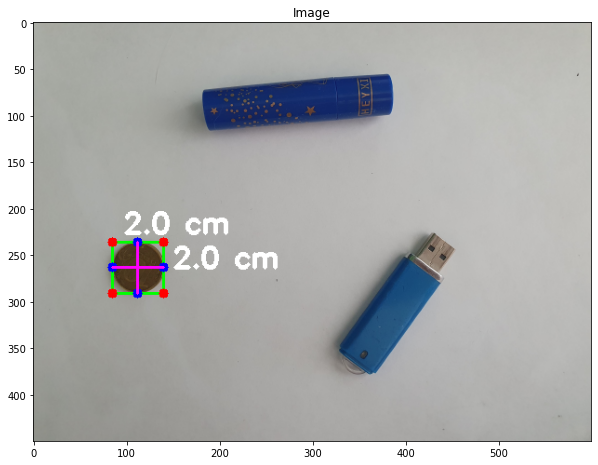

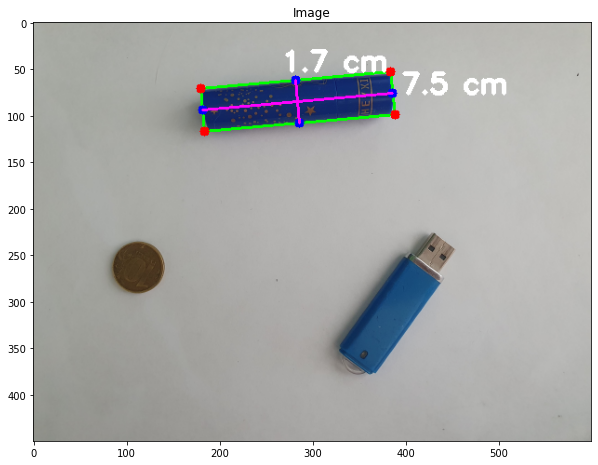

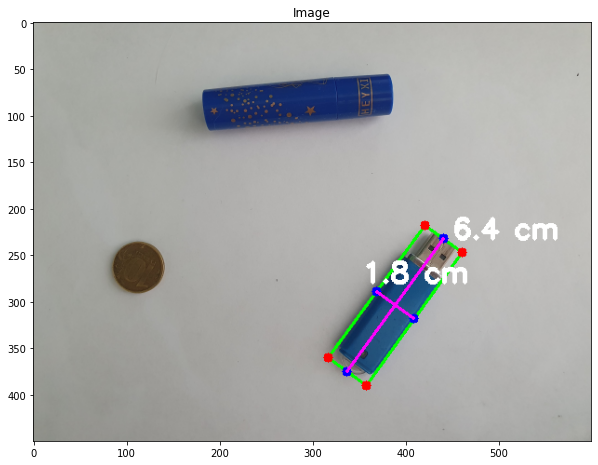

In [9]:
# loop over the contours individually
# перебираем отдельные контуры
for c in cnts:
	# if the contour is not sufficiently large, ignore it
    # если контур недостаточно большой, игнорируем его
	if cv2.contourArea(c) < 1000:
		continue

	# compute the rotated bounding box of the contour
    # вычисляем повернутую ограничивающую рамку контура
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")

	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
    # упорядочиваем точки контура так, чтобы они отображались
	# в верхнем левом, верхнем правом, нижнем правом и нижнем левом
	# углах, затем нарисуем контур рамки
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

	# loop over the original points and draw them
    # перебираем исходные точки и рисуем их
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
  
  	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
    # распаковываем упорядоченную ограничивающую рамку, затем вычисляем среднюю точку
    # между верхней левой и верхней правой координатами, за которыми следует
    # середина между нижней левой и нижней правой координатами
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)

	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
    # вычисляем среднюю точку между верхней левой и верхней правой точками,
	# за которыми следует середина между верхней правой и нижней правой точками
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)

	# draw the midpoints on the image
    # рисуем середину на изображении
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

	# draw lines between the midpoints
    # рисуем линии между серединами
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)
 
	# compute the Euclidean distance between the midpoints
    # вычисляем евклидово расстояние между серединами
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
    # если количество пикселей на метрику не было инициализировано, то
	# вычисляем его как отношение пикселей к предоставленной метрике
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / args["width"]

	# compute the size of the object
    # вычисляем размер объекта
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric

	# draw the object sizes on the image
    # рисуем размеры объекта на изображении
	cv2.putText(orig, "{:.1f} cm".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		1, (255, 255, 255), 3)
	cv2.putText(orig, "{:.1f} cm".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		1, (255, 255, 255), 3)

	# show the output image
    # показываем выходное изображение
	plt_imshow("Image", orig)